# <center>Predicting Molecular Properties</center>

## Imports

In [56]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import sweetviz as sv
import h2o
import pickle
import shutil

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import  train_test_split
from sklearn.linear_model import Ridge, ElasticNet, Lasso
from h2o.automl import H2OAutoML

## Datasets

In [12]:
import os
import pandas as pd
import gdown

# Diccionario con los nombres de archivos y sus IDs de Google Drive
files = {
    "train.csv": "15QRzYdMh7MchQUJqvkUhTKD5hl8egaea",
    "test.csv": "14wBV86t8xxP73mxrf9Mc4krW0AOnNrn8",
    "structures.csv": "1I-6FckhlJXyEF2Dji6_4LcSkOThY-yy3",
    "scalar_coupling_contributions.csv": "1HxYnb6aNRnEUlrB4lzHzwXznd3ebJfLJ",
    "potential_energy.csv": "1Hh46nJa8YEomfv9o4qd27Uo1EY0Gx0fg",
    "mulliken_charges.csv": "1HcHzXM-FePFXHz7TpCq4UYLptjcDRwEe",
    "magnetic_shielding_tensors.csv": "1HaHlZCX_SZDk_kvvIhBlHl57t27xkigK",
    "dipole_moments.csv": "1HaMzqZ7xzjc_vjQ3sh0jBUkGR9F0krIB"
}

# Directorio donde se guardarán los archivos
output_dir = 'champs-scalar-coupling'

# Crear la carpeta si no existe
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Función para descargar y leer un archivo CSV en un DataFrame utilizando gdown
def download_and_read_csv(file_id, file_name):
    output_path = os.path.join(output_dir, file_name)
    if not os.path.exists(output_path):
        url = f'https://drive.google.com/uc?id={file_id}'
        gdown.download(url, output_path, quiet=False)
    else:
        print(f"El archivo {file_name} ya existe en la carpeta {output_dir}, omitiendo la descarga.")
    return pd.read_csv(output_path)

# Diccionario para almacenar los DataFrames
dataframes = {}

# Descargar y leer cada archivo CSV en su correspondiente DataFrame
for file_name, file_id in files.items():
    df_name = f'df_{file_name.split(".")[0]}'
    dataframes[df_name] = download_and_read_csv(file_id, file_name)

El archivo train.csv ya existe en la carpeta champs-scalar-coupling, omitiendo la descarga.
El archivo test.csv ya existe en la carpeta champs-scalar-coupling, omitiendo la descarga.
El archivo structures.csv ya existe en la carpeta champs-scalar-coupling, omitiendo la descarga.
El archivo scalar_coupling_contributions.csv ya existe en la carpeta champs-scalar-coupling, omitiendo la descarga.
El archivo potential_energy.csv ya existe en la carpeta champs-scalar-coupling, omitiendo la descarga.
El archivo mulliken_charges.csv ya existe en la carpeta champs-scalar-coupling, omitiendo la descarga.
El archivo magnetic_shielding_tensors.csv ya existe en la carpeta champs-scalar-coupling, omitiendo la descarga.
El archivo dipole_moments.csv ya existe en la carpeta champs-scalar-coupling, omitiendo la descarga.
DataFrame df_train:
   id     molecule_name  atom_index_0  atom_index_1  type  \
0   0  dsgdb9nsd_000001             1             0  1JHC   
1   1  dsgdb9nsd_000001             1     

In [36]:

df_train = dataframes['df_train']
df_test = dataframes['df_test']

# Propiedades moleculares
df_dipole_moments = dataframes['df_dipole_moments']
df_potential_energy = dataframes['df_potential_energy']

# Propiedades atomicas
df_magnetic_shielding_tensors = dataframes['df_magnetic_shielding_tensors']
df_mulliken_charges = dataframes['df_mulliken_charges']
df_scalar_coupling_contributions = dataframes['df_scalar_coupling_contributions']
df_structures = dataframes['df_structures']

### Preprocesamiento

In [37]:
def merge_datasets(left_df, right_df, on=None, rename_columns=None, left_on=None, right_on=None):
    if rename_columns:
        left_df = left_df.rename(columns=rename_columns)
    if left_on and right_on:
        return pd.merge(left_df, right_df, how='inner', left_on=left_on, right_on=right_on)
    return pd.merge(left_df, right_df, how='inner', on=on)

# Primeros merges sin cambios
df = merge_datasets(df_scalar_coupling_contributions, df_train, on=['molecule_name', 'atom_index_0', 'atom_index_1', 'type'])
df = merge_datasets(df_dipole_moments, df, on=['molecule_name'])
df = merge_datasets(df_potential_energy, df, on=['molecule_name'])

# Merges con df_magnetic_shielding_tensors
df_magnetic_shielding_tensors_0 = df_magnetic_shielding_tensors.rename(columns={'XX':'XX_0', 'YX':'YX_0', 'ZX':'ZX_0', 'XY': 'XY_0', 'YY':'YY_0', 'ZY': 'ZY_0', 'XZ':'XZ_0', 'YZ': 'YZ_0', 'ZZ':'ZZ_0'})
df_magnetic_shielding_tensors_1 = df_magnetic_shielding_tensors.rename(columns={'XX':'XX_1', 'YX':'YX_1', 'ZX':'ZX_1', 'XY': 'XY_1', 'YY':'YY_1', 'ZY': 'ZY_1', 'XZ':'XZ_1', 'YZ':'YZ_1', 'ZZ':'ZZ_1'})

df = merge_datasets(df_magnetic_shielding_tensors_0, df, left_on=['molecule_name', 'atom_index'], right_on=['molecule_name', 'atom_index_0'])
df = merge_datasets(df_magnetic_shielding_tensors_1, df, left_on=['molecule_name', 'atom_index'], right_on=['molecule_name', 'atom_index_1'])
df.drop(['atom_index_x', 'atom_index_y'], axis=1, inplace=True)

# Merges con df_mulliken_charges
df_mulliken_charges_0 = df_mulliken_charges.rename(columns={'mulliken_charge':'mulliken_charge_0'})
df_mulliken_charges_1 = df_mulliken_charges.rename(columns={'mulliken_charge':'mulliken_charge_1'})

df = merge_datasets(df_mulliken_charges_0, df, left_on=['molecule_name', 'atom_index'], right_on=['molecule_name', 'atom_index_0'])
df = merge_datasets(df_mulliken_charges_1, df, left_on=['molecule_name', 'atom_index'], right_on=['molecule_name', 'atom_index_1'])
df.drop(['atom_index_x', 'atom_index_y'], axis=1, inplace=True)

# Merges con df_structures
df_structures_0 = df_structures.rename(columns={'atom': 'atom_0', 'x': 'x_0', 'y': 'y_0', 'z':'z_0'})
df_structures_1 = df_structures.rename(columns={'atom': 'atom_1', 'x': 'x_1', 'y': 'y_1', 'z':'z_1'})

df = merge_datasets(df_structures_0, df, left_on=['molecule_name', 'atom_index'], right_on=['molecule_name', 'atom_index_0'])
df = merge_datasets(df_structures_1, df, left_on=['molecule_name', 'atom_index'], right_on=['molecule_name', 'atom_index_1'])
df.drop(['atom_index_x', 'atom_index_y'], axis=1, inplace=True)

df.head()

,molecule_name,atom_1,x_1,y_1,z_1,atom_0,x_0,y_0,z_0,mulliken_charge_1,...,Z,atom_index_0,atom_index_1,type,fc,sd,pso,dso,id,scalar_coupling_constant
0,dsgdb9nsd_000001,C,-0.012698,1.085804,0.008001,H,0.002150,-0.006031,0.001976,-0.535689,...,0.0,1,0,1JHC,83.0224,0.254579,1.25862,0.272010,0,84.8076
1,dsgdb9nsd_000001,C,-0.012698,1.085804,0.008001,H,1.011731,1.463751,0.000277,-0.535689,...,0.0,2,0,1JHC,83.0222,0.254585,1.25861,0.272013,4,84.8074
2,dsgdb9nsd_000001,C,-0.012698,1.085804,0.008001,H,-0.540815,1.447527,-0.876644,-0.535689,...,0.0,3,0,1JHC,83.0241,0.254634,1.25856,0.272012,7,84.8093
3,dsgdb9nsd_000001,C,-0.012698,1.085804,0.008001,H,-0.523814,1.437933,0.906397,-0.535689,...,0.0,4,0,1JHC,83.0243,0.254628,1.25856,0.272012,9,84.8095
4,dsgdb9nsd_000001,H,1.011731,1.463751,0.000277,H,0.002150,-0.006031,0.001976,0.133922,...,0.0,1,2,2JHH,-11.0347,0.352978,2.85839,-3.433600,1,-11.2570


In [38]:
# Lista de columnas a ignorar
ignore_columns = ['atom_index_0', 'atom_index_1', 'atom_0', 'atom_1']


# distance between axis of atom
df['x_dist'] = (df['x_0'] - df['x_1'])**2
df['y_dist'] = (df['y_0'] - df['y_1'])**2
df['z_dist'] = (df['z_0'] - df['z_1'])**2

# distance between atom
df['atom_dist'] = (df['x_dist']+df['y_dist']+df['z_dist'])**0.5

df.drop(columns=['x_0','x_1','y_0','y_1','z_0','z_1'], inplace=True)
    

# Encuentra las columnas con sufijo _0 y _1
columns_0 = [col for col in df.columns if col.endswith('_0') and col not in ignore_columns]
columns_1 = [col for col in df.columns if col.endswith('_1') and col.replace('_1', '_0') in columns_0]


# Calcula la diferencia en valor absoluto y guárdala en nuevas columnas
for col_0 in columns_0:
    col_1 = col_0.replace('_0', '_1')
    if col_1 in df.columns:
        df[f'diff_{col_0[:-2]}'] = (df[col_0] - df[col_1]).abs()

# Eliminar las columnas _0 y _1 que se compararon
df.drop(columns=columns_0 + columns_1, inplace=True)

df.head()

,molecule_name,atom_1,atom_0,potential_energy,X,Y,Z,atom_index_0,atom_index_1,type,...,diff_mulliken_charge,diff_XX,diff_YX,diff_ZX,diff_XY,diff_YY,diff_ZY,diff_XZ,diff_YZ,diff_ZZ
0,dsgdb9nsd_000001,C,H,-40.52368,0.0,0.0,0.0,1,0,1JHC,...,0.669610,163.9737,1.2317,4.0545,1.2317,166.3625,1.7180,4.0547,1.7180,161.2308
1,dsgdb9nsd_000001,C,H,-40.52368,0.0,0.0,0.0,2,0,1JHC,...,0.669611,163.7333,1.2173,4.1473,1.2173,166.4135,1.6043,4.1475,1.6043,161.4202
2,dsgdb9nsd_000001,C,H,-40.52368,0.0,0.0,0.0,3,0,1JHC,...,0.669612,163.7975,4.1086,1.2724,4.1088,161.4103,1.6943,1.2725,1.6944,166.3590
3,dsgdb9nsd_000001,C,H,-40.52368,0.0,0.0,0.0,4,0,1JHC,...,0.669612,163.9118,4.0942,1.1792,4.0944,161.2395,1.6252,1.1794,1.6253,166.4156
4,dsgdb9nsd_000001,H,H,-40.52368,0.0,0.0,0.0,1,2,2JHH,...,0.000001,0.2404,2.4490,8.2018,2.4490,0.0510,0.1137,8.2022,0.1137,0.1894


In [39]:
columnas_ordenadas = ['id','molecule_name', 'potential_energy', 'X',
       'Y', 'Z',   'atom_index_0', 'atom_index_1', 'atom_0', 'atom_1', 
       'atom_dist', 'x_dist', 'y_dist', 'z_dist', 'diff_mulliken_charge', 
       'diff_XX', 'diff_YX', 'diff_ZX', 'diff_XY', 'diff_YY', 'diff_ZY', 
       'diff_XZ', 'diff_YZ', 'diff_ZZ', 'type', 'fc', 'sd', 'pso', 'dso', 
       'scalar_coupling_constant']
df=df[columnas_ordenadas]
df.set_index('id', inplace=True)


In [40]:
df = df.sort_values(by='id', ascending=True)

# Comprobar si el archivo ya existe
if not os.path.isfile('data_train.csv'):
    df.to_csv('data_train.csv')

In [41]:
df

,molecule_name,potential_energy,X,Y,Z,atom_index_0,atom_index_1,atom_0,atom_1,atom_dist,...,diff_ZY,diff_XZ,diff_YZ,diff_ZZ,type,fc,sd,pso,dso,scalar_coupling_constant
id,,,,,,,,,,,,,,,,,,,,,
0,dsgdb9nsd_000001,-40.523680,0.0000,0.0000,0.0,1,0,H,C,1.091953,...,1.7180,4.0547,1.7180,161.2308,1JHC,83.022400,0.254579,1.258620,0.272010,84.807600
1,dsgdb9nsd_000001,-40.523680,0.0000,0.0000,0.0,1,2,H,H,1.783120,...,0.1137,8.2022,0.1137,0.1894,2JHH,-11.034700,0.352978,2.858390,-3.433600,-11.257000
2,dsgdb9nsd_000001,-40.523680,0.0000,0.0000,0.0,1,3,H,H,1.783147,...,3.4123,2.7822,3.4124,5.1282,2JHH,-11.032500,0.352944,2.858520,-3.433870,-11.254800
3,dsgdb9nsd_000001,-40.523680,0.0000,0.0000,0.0,1,4,H,H,1.783157,...,3.3432,5.2341,3.3433,5.1848,2JHH,-11.031900,0.352934,2.858550,-3.433930,-11.254300
4,dsgdb9nsd_000001,-40.523680,0.0000,0.0000,0.0,2,0,H,C,1.091952,...,1.6043,4.1475,1.6043,161.4202,1JHC,83.022200,0.254585,1.258610,0.272013,84.807400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4659071,dsgdb9nsd_133884,-364.872596,1.3623,1.4058,-0.0,17,4,H,C,2.306538,...,6.3610,1.5392,4.0580,106.5590,2JHC,3.586440,0.019741,0.150477,-0.213205,3.543450
4659072,dsgdb9nsd_133884,-364.872596,1.3623,1.4058,-0.0,17,5,H,C,3.495226,...,6.3610,1.5378,4.0579,113.8286,3JHC,0.674583,-0.007276,0.305078,-0.403388,0.568997
4659073,dsgdb9nsd_133884,-364.872596,1.3623,1.4058,-0.0,17,6,H,C,3.397424,...,6.3618,1.5378,4.0588,73.6259,3JHC,1.337470,-0.028423,0.312240,-0.447920,1.173370


## Analisis

In [42]:
# Generar un informe de análisis exploratorio de datos
report = sv.analyze(df, target_feat="scalar_coupling_constant")

In [43]:
# Mostrar el informe
report.show_notebook(layout='widescreen')

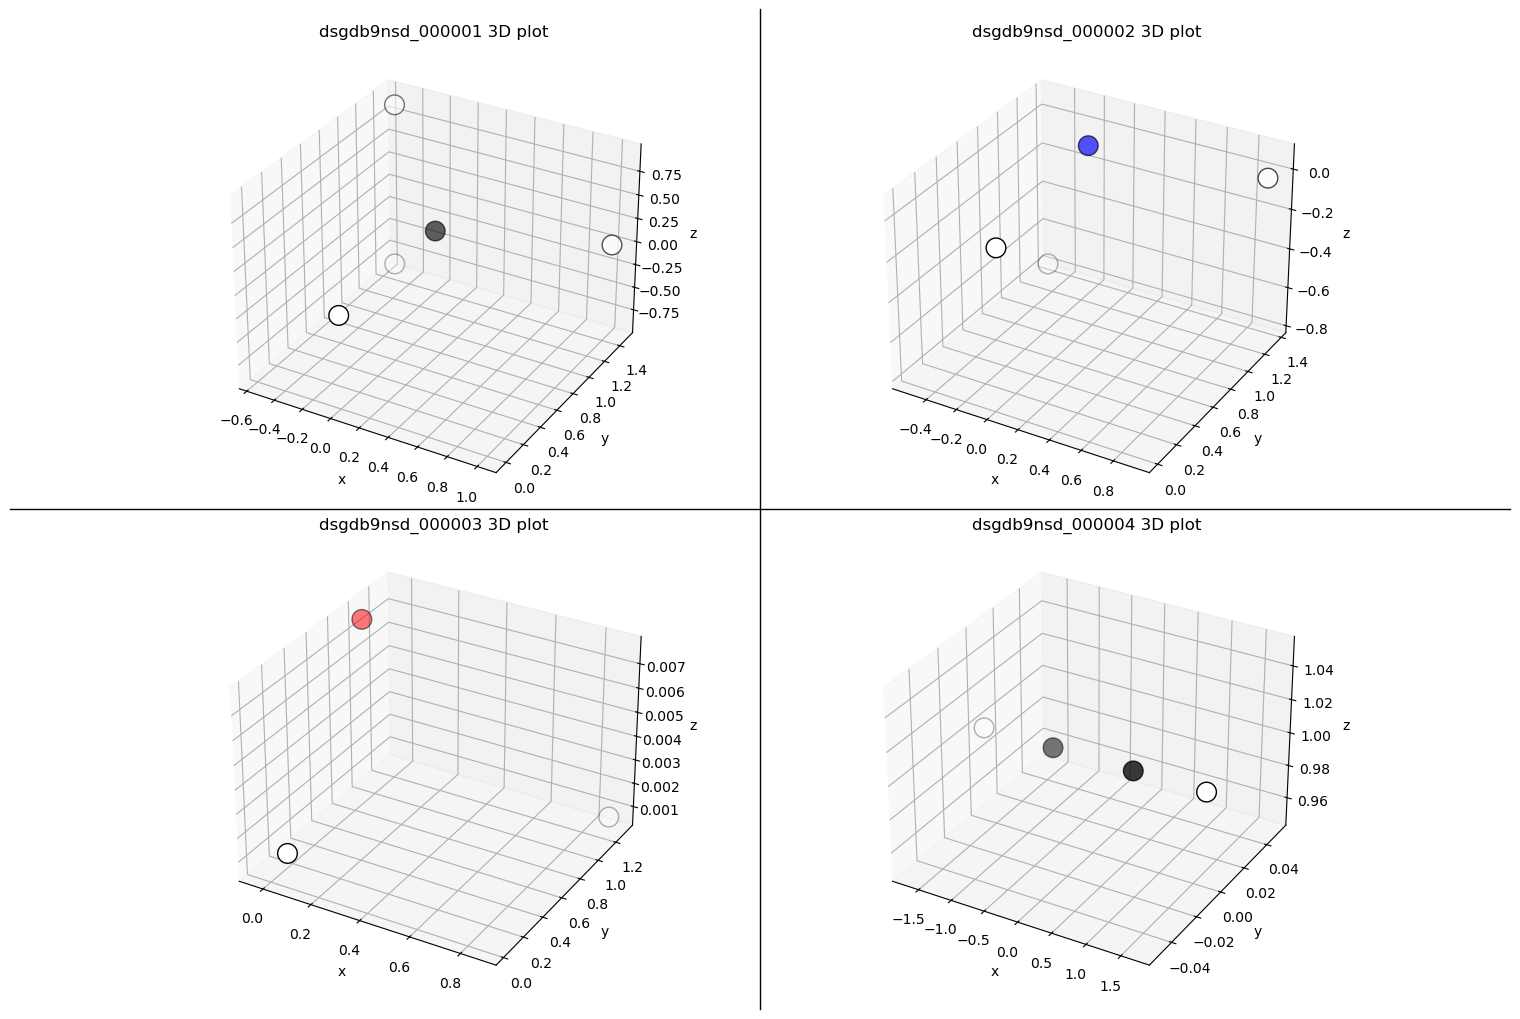

In [44]:
# Definir los colores CPK para cada tipo de átomo
atom_colors = {'C': 'black', 'H': 'white', 'N': 'blue', 'O': 'red'}

# Crear una figura con 2x2 subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 10), subplot_kw={'projection': '3d'})

# Obtener los nombres únicos de las moléculas y seleccionar los primeros 4
unique_molecules = df_structures['molecule_name'].unique()[:4]

# Recorrer los nombres de las moléculas y crear un subplot para cada uno
for ax, name in zip(axs.ravel(), unique_molecules):
    structures_molecule = df_structures[df_structures['molecule_name'] == name]
    colors = structures_molecule['atom'].map(atom_colors)
    ax.scatter(structures_molecule['x'], structures_molecule['y'], structures_molecule['z'], s=200, edgecolors='black', c=colors)
    ax.set_title(f'{name} 3D plot')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')

# Añadir líneas de separación horizontales
fig.add_artist(plt.Line2D([0.5, 0.5], [0, 1], transform=fig.transFigure, color='black', linewidth=1))

# Añadir líneas de separación verticales
fig.add_artist(plt.Line2D([0, 1], [0.5, 0.5], transform=fig.transFigure, color='black', linewidth=1))

# Ajustar el layout para evitar solapamientos
plt.tight_layout()
plt.show()


## Procesamiento

In [45]:
df = df.drop(columns=['molecule_name', 'potential_energy', 'atom_index_0','atom_index_1', 'atom_0', 'atom_1', 'X', 'Y', 'Z', 'fc', 'sd', 'pso', 'dso'])

In [46]:
# Detectar columnas categóricas
categorical_cols = df.select_dtypes(include=['object']).columns

# Diccionario para almacenar los LabelEncoders
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le
    
# Guardar los LabelEncoders en un archivo
with open('web/label_encoders.pkl', 'wb') as file:
    pickle.dump(label_encoders, file)
    
df.head()

,atom_dist,x_dist,y_dist,z_dist,diff_mulliken_charge,diff_XX,diff_YX,diff_ZX,diff_XY,diff_YY,diff_ZY,diff_XZ,diff_YZ,diff_ZZ,type,scalar_coupling_constant
id,,,,,,,,,,,,,,,,
0,1.091953,0.000220,1.192105,0.000036,0.669610,163.9737,1.2317,4.0545,1.2317,166.3625,1.7180,4.0547,1.7180,161.2308,0,84.8076
1,1.783120,1.019253,2.160261,0.000003,0.000001,0.2404,2.4490,8.2018,2.4490,0.0510,0.1137,8.2022,0.1137,0.1894,3,-11.2570
2,1.783147,0.294812,2.112831,0.771973,0.000002,0.1762,5.3403,2.7821,5.3405,4.9522,3.4123,2.7822,3.4124,5.1282,3,-11.2548
3,1.783157,0.276638,2.085032,0.817978,0.000002,0.0619,2.8625,5.2337,2.8627,5.1230,3.3432,5.2341,3.3433,5.1848,3,-11.2543
4,1.091952,1.049455,0.142844,0.000060,0.669611,163.7333,1.2173,4.1473,1.2173,166.4135,1.6043,4.1475,1.6043,161.4202,0,84.8074


In [47]:
targets_columns =['scalar_coupling_constant']

features = df.drop(columns=targets_columns)
target = df[targets_columns]

scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Convertir de nuevo a DataFrame
scaled_df = pd.DataFrame(scaled_features, columns=features.columns)
scaled_df[targets_columns] = target

scaled_df.head()

,atom_dist,x_dist,y_dist,z_dist,diff_mulliken_charge,diff_XX,diff_YX,diff_ZX,diff_XY,diff_YY,diff_ZY,diff_XZ,diff_YZ,diff_ZZ,type,scalar_coupling_constant
0,-1.722504,-0.842474,-0.418144,-0.830621,2.400740,1.149649,-0.659427,-0.423913,-0.662537,1.404145,-0.579596,-0.432772,-0.582470,1.410727,-1.646511,84.8076
1,-0.784427,-0.406141,-0.034004,-0.830636,-1.248108,-1.457098,-0.598573,-0.159145,-0.600853,-1.451386,-0.692138,-0.176132,-0.692673,-1.597671,-0.226012,-11.2570
2,-0.784389,-0.716335,-0.052823,-0.493824,-1.248103,-1.458120,-0.454034,-0.505144,-0.454332,-1.367234,-0.460740,-0.511512,-0.466077,-1.505410,-0.226012,-11.2548
3,-0.784377,-0.724116,-0.063853,-0.473752,-1.248103,-1.459940,-0.577902,-0.348632,-0.579889,-1.364301,-0.465587,-0.359793,-0.470823,-1.504353,-0.226012,-11.2543
4,-1.722506,-0.393209,-0.834464,-0.830611,2.400745,1.145821,-0.660147,-0.417989,-0.663266,1.405020,-0.587572,-0.427030,-0.590280,1.414265,-1.646511,84.8074


## Selección de características

In [48]:
X = scaled_df.drop(columns=targets_columns, axis=1)
y = scaled_df['scalar_coupling_constant']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [49]:
# Crear y entrenar modelos
ridge_model = Ridge(alpha=1.0)
lasso_model = Lasso(alpha=1.0)
elastic_net_model = ElasticNet(alpha=1.0, l1_ratio=0.5)

ridge_model.fit(X_train, y_train)
lasso_model.fit(X_train, y_train)
elastic_net_model.fit(X_train, y_train)

# Obtener los coeficientes
ridge_coefficients = ridge_model.coef_
lasso_coefficients = lasso_model.coef_
elastic_net_coefficients = elastic_net_model.coef_

# Crear un DataFrame para comparar los coeficientes
coef_df = pd.DataFrame({
    'Característica': X.columns,
    'Ridge': ridge_coefficients,
    'Lasso': lasso_coefficients,
    'ElasticNet': elastic_net_coefficients
})

# Ordenar el DataFrame por las columnas de coeficientes
coef_df = coef_df.sort_values(by=['Ridge', 'Lasso', 'ElasticNet'])

# Definir una función para resaltar los 10 valores más bajos en verde (ignorando los ceros)
def highlight_top_10(s):
    # Filtrar los ceros
    s_no_zeros = s[s != 0]
    
    if len(s_no_zeros) > 10:
        threshold = s_no_zeros.nsmallest(10).iloc[-1]
        top_10 = s.apply(lambda x: x <= threshold if x != 0 else False)
    else:
        top_10 = s.apply(lambda x: x != 0)
    
    return ['color: green' if v else '' for v in top_10]

# Aplicar el formato al DataFrame
styled_coef_df = coef_df.style.apply(highlight_top_10, subset=['Ridge', 'Lasso', 'ElasticNet'])

# Mostrar el DataFrame estilizado
styled_coef_df

,Característica,Ridge,Lasso,ElasticNet
0,atom_dist,-148.306841,-17.215655,-9.720183
12,diff_YZ,-0.601598,0.000000,0.000000
11,diff_XZ,-0.409115,0.000000,-0.000000
4,diff_mulliken_charge,-0.149361,6.940657,4.407578
8,diff_XY,0.020226,0.000000,0.000000
6,diff_YX,0.703702,0.000000,0.000000
9,diff_YY,0.751089,0.000000,0.661943
7,diff_ZX,0.795553,0.000000,0.000000
10,diff_ZY,0.889557,0.000000,0.000000
5,diff_XX,1.048185,0.185793,0.699842


## Entrenamiento

In [50]:
# Inicializa el clúster de H2O
h2o.init(min_mem_size="6G", max_mem_size="12G")

# Convierte el DataFrame de pandas a un H2OFrame
data = h2o.H2OFrame(scaled_df)

# Define la columna de objetivo y las características
y = "scalar_coupling_constant"  
x = data.columns
x.remove(y)

# Divide el dataset en entrenamiento, prueba y validación
train, val, test = data.split_frame(ratios=[.6, .2])

# Inicializa y entrena el modelo de AutoML
aml = H2OAutoML(max_runtime_secs=3600, seed=1, nfolds=0)
aml.train(x=x, y=y, training_frame=train, validation_frame=val)

# Visualiza el líder del AutoML
lb = aml.leaderboard
print(lb)


Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,1 hour 56 mins
H2O_cluster_timezone:,Europe/London
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.2
H2O_cluster_version_age:,"7 days, 18 hours and 54 minutes"
H2O_cluster_name:,H2O_from_python_maqui_l68cxr
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,4.562 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |█
10:25:55.625: AutoML: XGBoost is not available; skipping it.

██████████████████████████████████████████████████████████████| (done) 100%
model_id                                         rmse      mse      mae    rmsle    mean_residual_deviance
GBM_grid_1_AutoML_2_20240521_102555_model_5   2.5077   6.28858  1.58163      nan                   6.28858
GBM_1_AutoML_2_20240521_102555                2.69115  7.2423   1.71801      nan                   7.2423
DRF_1_AutoML_2_20240521_102555                2.73232  7.46559  1.75811      nan                   7.46559
GBM_grid_1_AutoML_2_20240521_102555_model_27  2.7328   7.46819  1.7514       nan                   7.46819
GBM_grid_1_AutoML_2_20240521_102555_model_4   2.75107  7.56841  1.7698       nan                   7.56841
XRT_1_AutoML_2_20240521_102555                2.7551   7.59059  1.77366      nan                   7.59059

In [51]:
# Listamos los 10 mejores modelos
top_10_models = lb.head(10)['model_id'].as_data_frame().iloc[:,0].tolist()

# Inicializa listas para almacenar las métricas
rmse_list = []
mae_list = []
model_names = []

# Itera sobre los mejores modelos y calcula las métricas
for model_id in top_10_models:
    model = h2o.get_model(model_id)
    predictions = model.predict(test)
    performance = model.model_performance(test)
    
    rmse_list.append(performance.rmse())
    mae_list.append(performance.mae())
    model_names.append(model_id)

# Crea un DataFrame con las métricas
results_df = pd.DataFrame({
    'Model': model_names,
    'RMSE': rmse_list,
    'MAE': mae_list
})

print(results_df)

c:\Users\maqui\anaconda3\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
                                          Model   

### Resultados

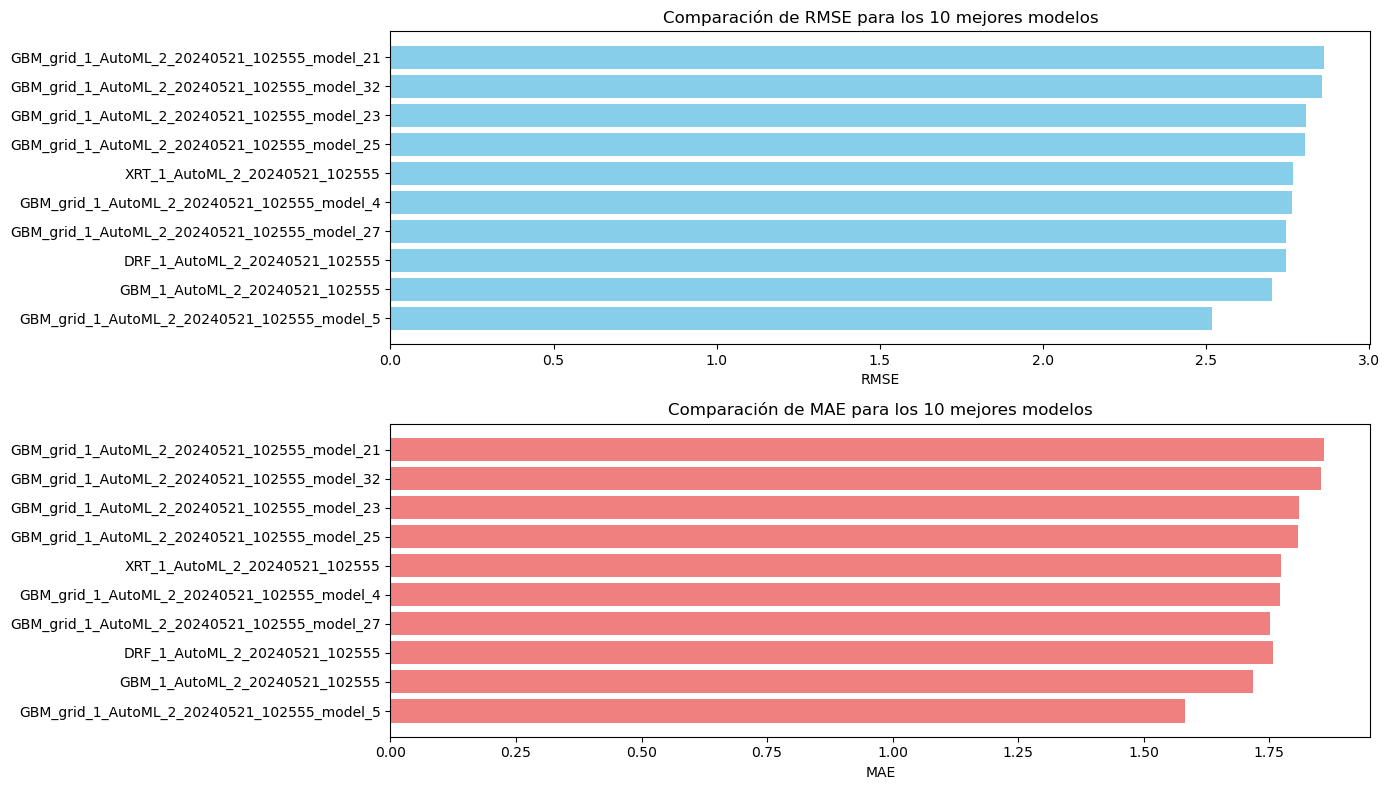

In [52]:
# Configura el tamaño de la figura
plt.figure(figsize=(14, 8))

# Gráfica de barras para RMSE
plt.subplot(2, 1, 1)
plt.barh(results_df['Model'], results_df['RMSE'], color='skyblue')
plt.xlabel('RMSE')
plt.title('Comparación de RMSE para los 10 mejores modelos')

# Gráfica de barras para MAE
plt.subplot(2, 1, 2)
plt.barh(results_df['Model'], results_df['MAE'], color='lightcoral')
plt.xlabel('MAE')
plt.title('Comparación de MAE para los 10 mejores modelos')

# Ajusta el layout
plt.tight_layout()
plt.show()

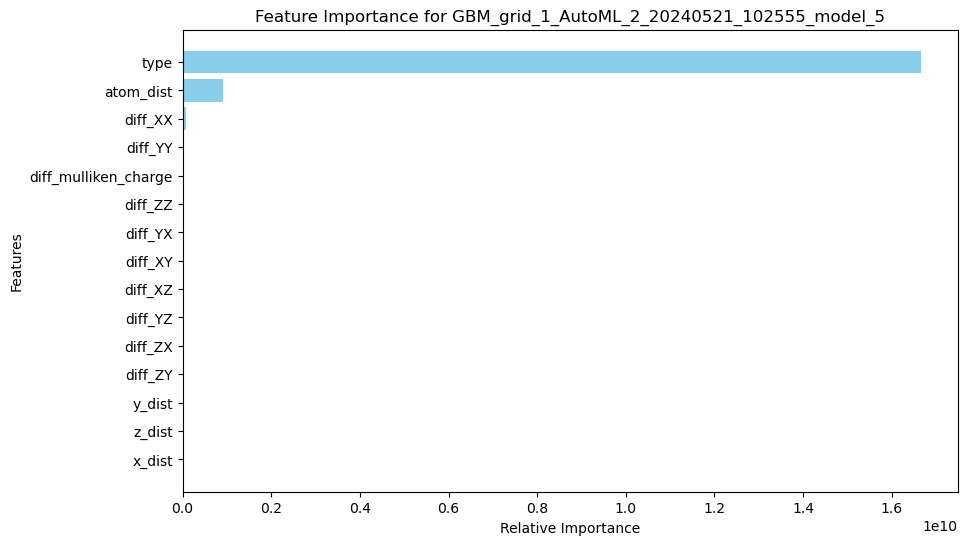

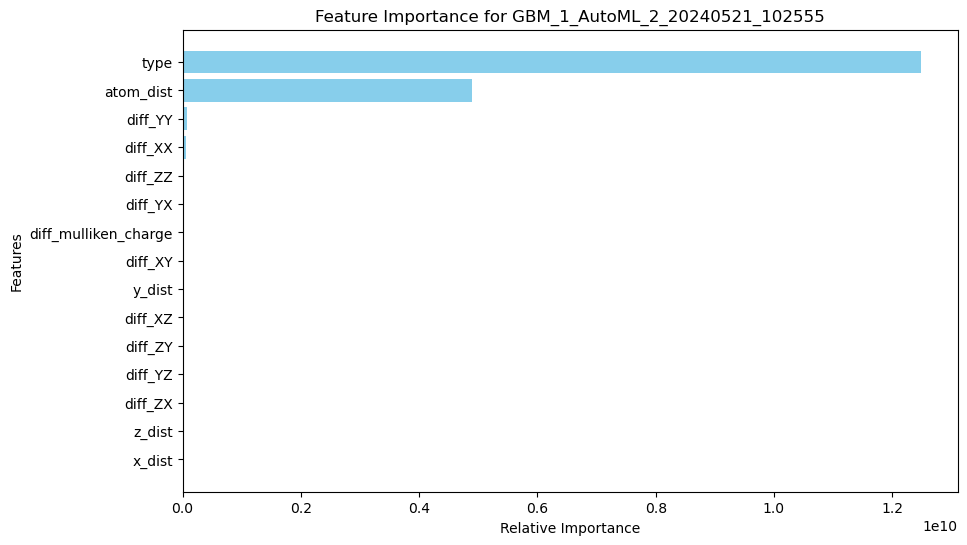

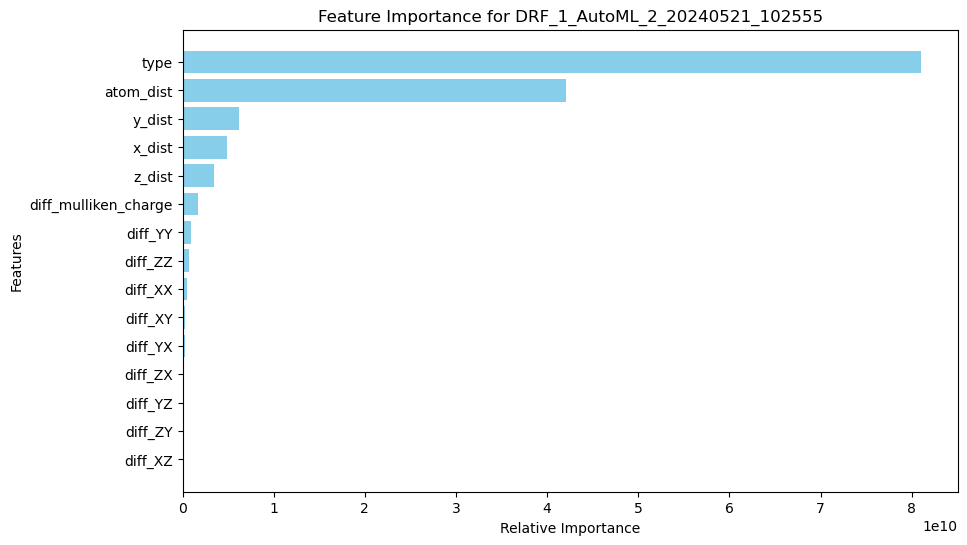

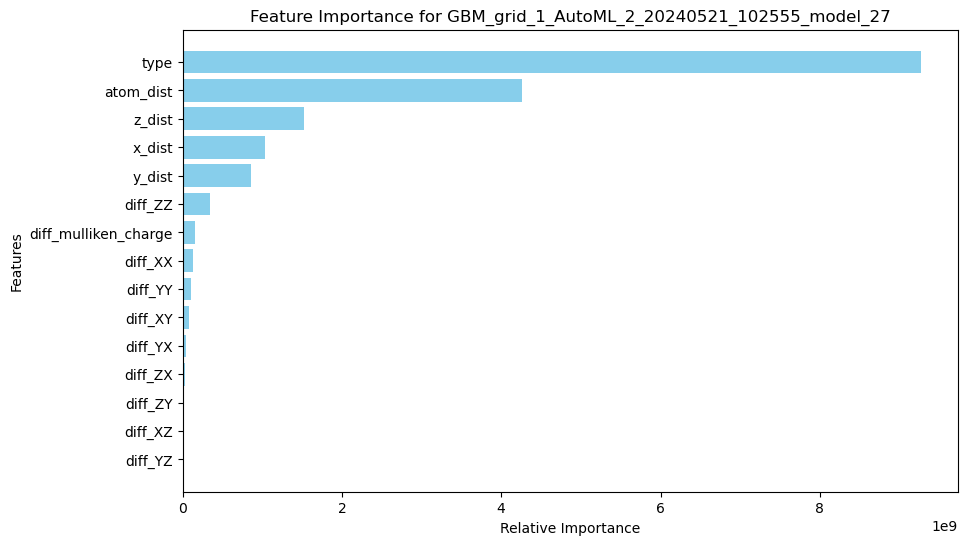

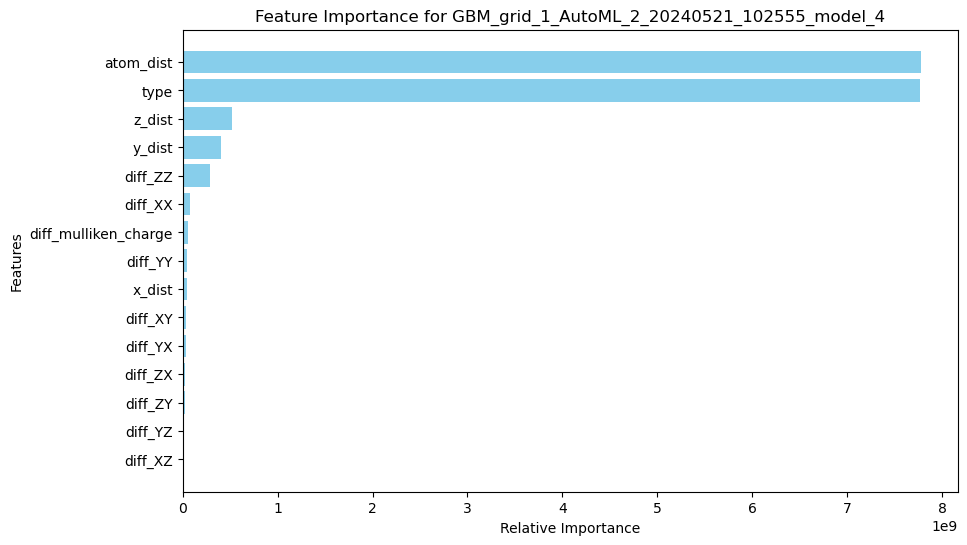

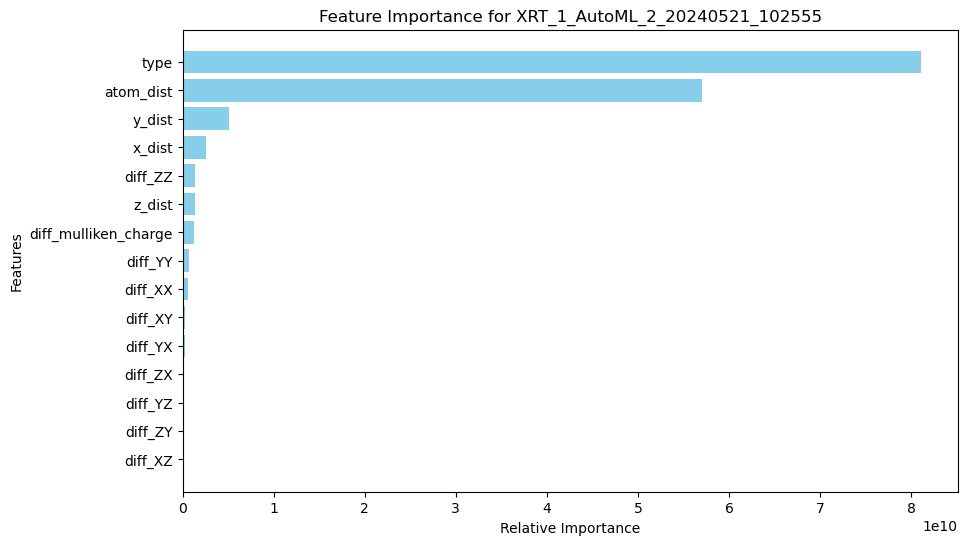

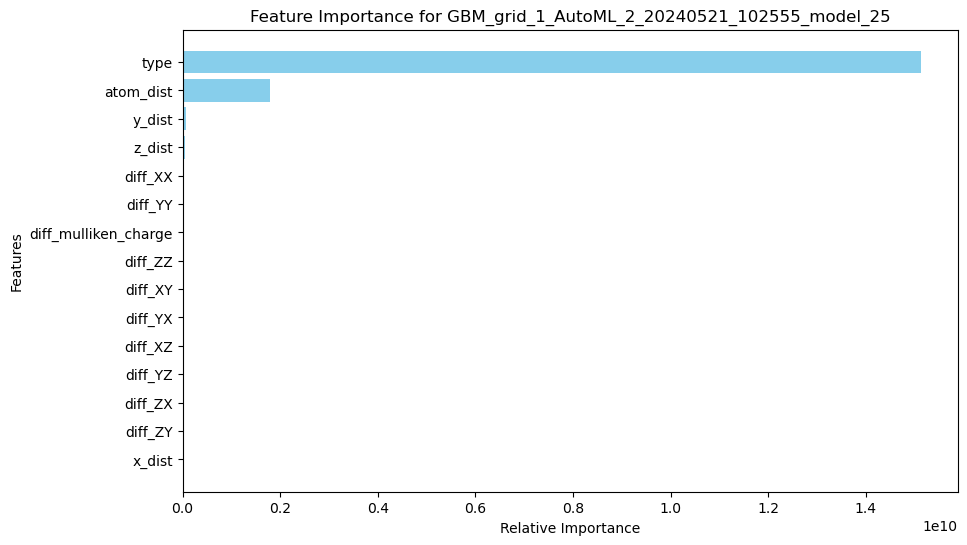

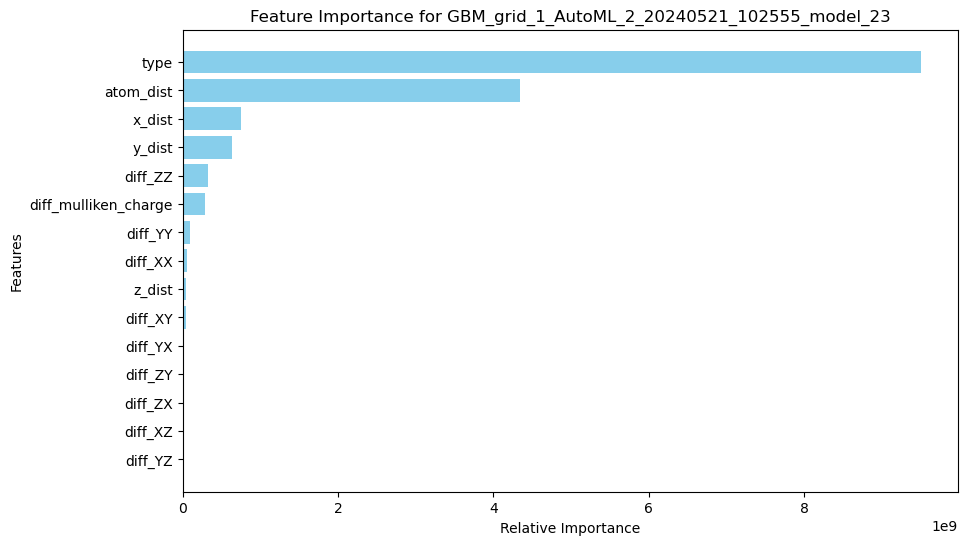

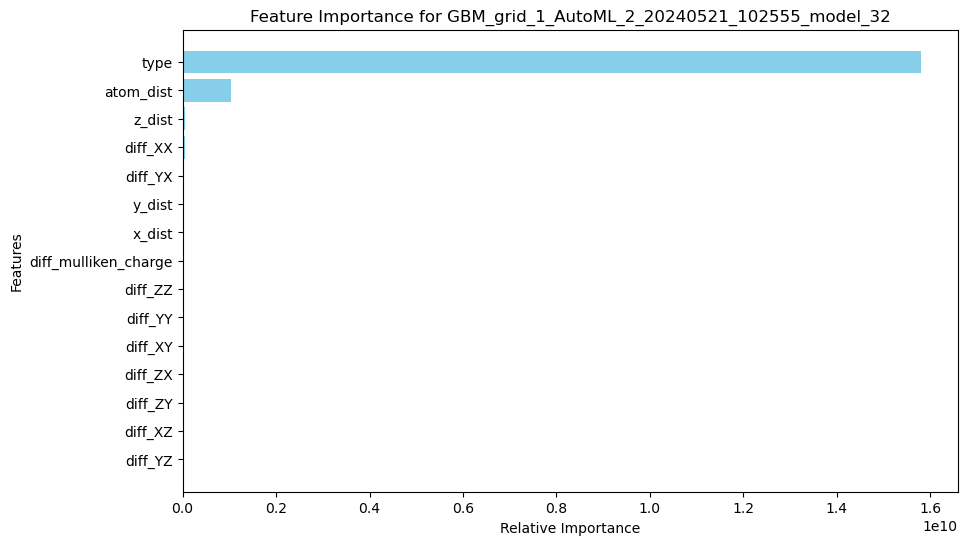

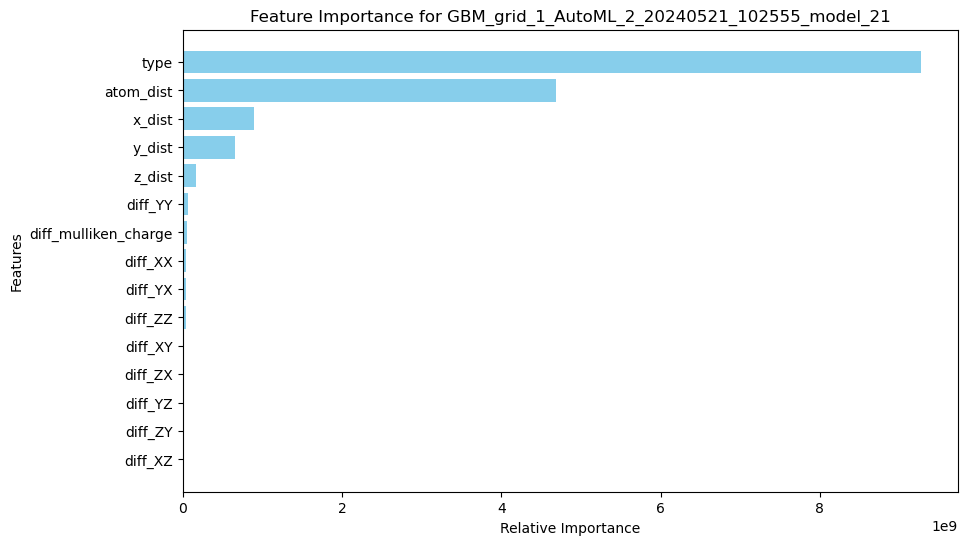

In [53]:
for model_id in top_10_models:
    model = h2o.get_model(model_id)
    # Obtener la importancia de las características
    varimp = model.varimp()

    # Convertir a DataFrame de pandas para mejor visualización
    varimp_df = pd.DataFrame(varimp, columns=["Variable", "Relative Importance", "Scaled Importance", "Percentage"])

    # Visualizar la importancia de las características con matplotlib
    plt.figure(figsize=(10, 6))
    plt.barh(varimp_df['Variable'], varimp_df['Relative Importance'], color='skyblue')
    plt.xlabel('Relative Importance')
    plt.ylabel('Features')
    plt.title('Feature Importance for ' + model_id)
    plt.gca().invert_yaxis()  # Invertir el eje y para mostrar las características más importantes primero
    plt.show()

### Guardar modelo entrenado

In [57]:
# Obtener el mejor modelo de AutoML
best_model = aml.leader

model_name = best_model.model_id

# Guardar el mejor modelo
model_path = h2o.save_model(model=best_model, path="model_trained", force=True)
path = os.path.join(os.path.dirname(model_path), 'modelo_entrenado')

# Renombra el archivo guardado (sobrescribe si ya existe)
if os.path.exists(path):
    os.remove(path)
shutil.move(model_path, path)

print(f"Modelo guardado en: {path}")

Modelo guardado en: G:\Mi unidad\Master FP IA y BD\PROYECTO FINAL\web\model_trained\modelo_entrenado


## Resultados

In [61]:
# Cargar el modelo
loaded_model = h2o.load_model(path)

# Verificar que el modelo cargado funciona
performance = loaded_model.model_performance(test)
print("MAE", performance.mae())

MAE 1.5827669836209952


### Dataset Test

### Preprocesamiento de Test

In [63]:
def merge_datasets(left_df, right_df, on=None, rename_columns=None, left_on=None, right_on=None):
    if rename_columns:
        left_df = left_df.rename(columns=rename_columns)
    if left_on and right_on:
        return pd.merge(left_df, right_df, how='inner', left_on=left_on, right_on=right_on)
    return pd.merge(left_df, right_df, how='inner', on=on)

# Primeros merges sin cambios
df_test = merge_datasets(df_dipole_moments, df_test, on=['molecule_name'])
df_test = merge_datasets(df_potential_energy, df_test, on=['molecule_name'])

# Merges con df_magnetic_shielding_tensors
df_magnetic_shielding_tensors_0 = df_magnetic_shielding_tensors.rename(columns={'XX':'XX_0', 'YX':'YX_0', 'ZX':'ZX_0', 'XY': 'XY_0', 'YY':'YY_0', 'ZY': 'ZY_0', 'XZ':'XZ_0', 'YZ': 'YZ_0', 'ZZ':'ZZ_0'})
df_magnetic_shielding_tensors_1 = df_magnetic_shielding_tensors.rename(columns={'XX':'XX_1', 'YX':'YX_1', 'ZX':'ZX_1', 'XY': 'XY_1', 'YY':'YY_1', 'ZY': 'ZY_1', 'XZ':'XZ_1', 'YZ':'YZ_1', 'ZZ':'ZZ_1'})

df_test = merge_datasets(df_magnetic_shielding_tensors_0, df_test, left_on=['molecule_name', 'atom_index'], right_on=['molecule_name', 'atom_index_0'])
df_test = merge_datasets(df_magnetic_shielding_tensors_1, df_test, left_on=['molecule_name', 'atom_index'], right_on=['molecule_name', 'atom_index_1'])
df_test.drop(['atom_index_x', 'atom_index_y'], axis=1, inplace=True)

# Merges con df_mulliken_charges
df_mulliken_charges_0 = df_mulliken_charges.rename(columns={'mulliken_charge':'mulliken_charge_0'})
df_mulliken_charges_1 = df_mulliken_charges.rename(columns={'mulliken_charge':'mulliken_charge_1'})

df_test = merge_datasets(df_mulliken_charges_0, df_test, left_on=['molecule_name', 'atom_index'], right_on=['molecule_name', 'atom_index_0'])
df_test = merge_datasets(df_mulliken_charges_1, df_test, left_on=['molecule_name', 'atom_index'], right_on=['molecule_name', 'atom_index_1'])
df_test.drop(['atom_index_x', 'atom_index_y'], axis=1, inplace=True)

# Merges con df_structures
df_structures_0 = df_structures.rename(columns={'atom': 'atom_0', 'x': 'x_0', 'y': 'y_0', 'z':'z_0'})
df_structures_1 = df_structures.rename(columns={'atom': 'atom_1', 'x': 'x_1', 'y': 'y_1', 'z':'z_1'})

df_test = merge_datasets(df_structures_0, df_test, left_on=['molecule_name', 'atom_index'], right_on=['molecule_name', 'atom_index_0'])
df_test = merge_datasets(df_structures_1, df_test, left_on=['molecule_name', 'atom_index'], right_on=['molecule_name', 'atom_index_1'])
df_test.drop(['atom_index_x', 'atom_index_y'], axis=1, inplace=True)

df_test.head()

,molecule_name,atom_1,x_1,y_1,z_1,atom_0,x_0,y_0,z_0,mulliken_charge_1,...,YZ_0,ZZ_0,potential_energy,X,Y,Z,id,atom_index_0,atom_index_1,type
0,dsgdb9nsd_000004,C,0.599539,0.0,1.0,H,-1.661639,0.0,1.0,-0.20702,...,0.0,40.7169,-77.335268,0.0,0.0,0.0,4659076,2,0,2JHC
1,dsgdb9nsd_000004,C,0.599539,0.0,1.0,H,1.661639,0.0,1.0,-0.20702,...,0.0,40.7169,-77.335268,0.0,0.0,0.0,4659079,3,0,1JHC
2,dsgdb9nsd_000004,C,-0.599539,0.0,1.0,H,-1.661639,0.0,1.0,-0.20702,...,0.0,40.7169,-77.335268,0.0,0.0,0.0,4659077,2,1,1JHC
3,dsgdb9nsd_000004,C,-0.599539,0.0,1.0,H,1.661639,0.0,1.0,-0.20702,...,0.0,40.7169,-77.335268,0.0,0.0,0.0,4659080,3,1,2JHC
4,dsgdb9nsd_000004,H,1.661639,0.0,1.0,H,-1.661639,0.0,1.0,0.20702,...,0.0,40.7169,-77.335268,0.0,0.0,0.0,4659078,2,3,3JHH


In [64]:
# Lista de columnas a ignorar
ignore_columns = ['atom_index_0', 'atom_index_1', 'atom_0', 'atom_1']

# distance between axis of atom
df_test['x_dist'] = (df_test['x_0'] - df_test['x_1'])**2
df_test['y_dist'] = (df_test['y_0'] - df_test['y_1'])**2
df_test['z_dist'] = (df_test['z_0'] - df_test['z_1'])**2

# distance between atom
df_test['atom_dist'] = (df_test['x_dist']+df_test['y_dist']+df_test['z_dist'])**0.5

df_test.drop(columns=['x_0','x_1','y_0','y_1','z_0','z_1'], inplace=True)
    

# Encuentra las columnas con sufijo _0 y _1
columns_0 = [col for col in df_test.columns if col.endswith('_0') and col not in ignore_columns]
columns_1 = [col for col in df_test.columns if col.endswith('_1') and col.replace('_1', '_0') in columns_0]


# Calcula la diferencia en valor absoluto y guárdala en nuevas columnas
for col_0 in columns_0:
    col_1 = col_0.replace('_0', '_1')
    if col_1 in df_test.columns:
        df_test[f'diff_{col_0[:-2]}'] = (df_test[col_0] - df_test[col_1]).abs()

# Eliminar las columnas _0 y _1 que se compararon
df_test.drop(columns=columns_0 + columns_1, inplace=True)

df_test.head()

,molecule_name,atom_1,atom_0,potential_energy,X,Y,Z,id,atom_index_0,atom_index_1,...,diff_mulliken_charge,diff_XX,diff_YX,diff_ZX,diff_XY,diff_YY,diff_ZY,diff_XZ,diff_YZ,diff_ZZ
0,dsgdb9nsd_000004,C,H,-77.335268,0.0,0.0,0.0,4659076,2,0,...,0.41404,25.0425,0.0,0.0,0.0,25.0425,0.0,0.0,0.0,238.2506
1,dsgdb9nsd_000004,C,H,-77.335268,0.0,0.0,0.0,4659079,3,0,...,0.41404,25.0425,0.0,0.0,0.0,25.0425,0.0,0.0,0.0,238.2506
2,dsgdb9nsd_000004,C,H,-77.335268,0.0,0.0,0.0,4659077,2,1,...,0.41404,25.0425,0.0,0.0,0.0,25.0425,0.0,0.0,0.0,238.2506
3,dsgdb9nsd_000004,C,H,-77.335268,0.0,0.0,0.0,4659080,3,1,...,0.41404,25.0425,0.0,0.0,0.0,25.0425,0.0,0.0,0.0,238.2506
4,dsgdb9nsd_000004,H,H,-77.335268,0.0,0.0,0.0,4659078,2,3,...,0.00000,0.0000,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0000


In [65]:
columnas_ordenadas = ['id','molecule_name', 'potential_energy', 'X',
       'Y', 'Z',   'atom_index_0', 'atom_index_1', 'atom_0', 'atom_1', 
       'atom_dist', 'x_dist', 'y_dist', 'z_dist', 'diff_mulliken_charge', 
       'diff_XX', 'diff_YX', 'diff_ZX', 'diff_XY', 'diff_YY', 'diff_ZY', 
       'diff_XZ', 'diff_YZ', 'diff_ZZ', 'type']
df_test=df_test[columnas_ordenadas]
df_test.set_index('id', inplace=True)

In [66]:
df_test = df_test.sort_values(by='id', ascending=True)

# Comprobar si el archivo ya existe
if not os.path.isfile('data_test.csv'):
    df_test.to_csv('data_test.csv')

In [67]:
df_test

,molecule_name,potential_energy,X,Y,Z,atom_index_0,atom_index_1,atom_0,atom_1,atom_dist,...,diff_XX,diff_YX,diff_ZX,diff_XY,diff_YY,diff_ZY,diff_XZ,diff_YZ,diff_ZZ,type
id,,,,,,,,,,,,,,,,,,,,,
4659076,dsgdb9nsd_000004,-77.335268,0.0000,0.0000,0.0,2,0,H,C,2.261178,...,25.0425,0.0000,0.0000,0.0000,25.0425,0.0000,0.0000,0.0000,238.2506,2JHC
4659077,dsgdb9nsd_000004,-77.335268,0.0000,0.0000,0.0,2,1,H,C,1.062099,...,25.0425,0.0000,0.0000,0.0000,25.0425,0.0000,0.0000,0.0000,238.2506,1JHC
4659078,dsgdb9nsd_000004,-77.335268,0.0000,0.0000,0.0,2,3,H,H,3.323277,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,3JHH
4659079,dsgdb9nsd_000004,-77.335268,0.0000,0.0000,0.0,3,0,H,C,1.062099,...,25.0425,0.0000,0.0000,0.0000,25.0425,0.0000,0.0000,0.0000,238.2506,1JHC
4659080,dsgdb9nsd_000004,-77.335268,0.0000,0.0000,0.0,3,1,H,C,2.261178,...,25.0425,0.0000,0.0000,0.0000,25.0425,0.0000,0.0000,0.0000,238.2506,2JHC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7164261,dsgdb9nsd_133885,-400.760914,-0.8578,-0.0909,-0.0,15,3,H,C,2.307978,...,166.8233,12.0892,12.2169,16.3376,123.5142,0.8312,3.4343,8.7215,113.0481,2JHC
7164262,dsgdb9nsd_133885,-400.760914,-0.8578,-0.0909,-0.0,15,4,H,C,2.314978,...,107.6592,55.5884,6.3049,38.0769,82.9990,5.6073,2.3131,3.7458,72.2927,2JHC
7164263,dsgdb9nsd_133885,-400.760914,-0.8578,-0.0909,-0.0,15,6,H,C,3.343890,...,95.9844,15.0938,6.3054,61.5832,122.9967,5.6077,2.3144,3.7468,62.1805,3JHC


### Procesamiento de Test

In [68]:
df_test = df_test.drop(columns=['molecule_name', 'potential_energy', 'atom_index_0','atom_index_1', 'atom_0', 'atom_1', 'X', 'Y', 'Z'])

In [69]:
# Detectar columnas categóricas
categorical_cols = df_test.select_dtypes(include=['object']).columns

for col in categorical_cols:
    le = LabelEncoder()
    df_test[col] = le.fit_transform(df_test[col])
    
df_test.head()

,atom_dist,x_dist,y_dist,z_dist,diff_mulliken_charge,diff_XX,diff_YX,diff_ZX,diff_XY,diff_YY,diff_ZY,diff_XZ,diff_YZ,diff_ZZ,type
id,,,,,,,,,,,,,,,
4659076,2.261178,5.112926,0.0,0.0,0.41404,25.0425,0.0,0.0,0.0,25.0425,0.0,0.0,0.0,238.2506,2
4659077,1.062099,1.128054,0.0,0.0,0.41404,25.0425,0.0,0.0,0.0,25.0425,0.0,0.0,0.0,238.2506,0
4659078,3.323277,11.044171,0.0,0.0,0.00000,0.0000,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0000,6
4659079,1.062099,1.128054,0.0,0.0,0.41404,25.0425,0.0,0.0,0.0,25.0425,0.0,0.0,0.0,238.2506,0
4659080,2.261178,5.112926,0.0,0.0,0.41404,25.0425,0.0,0.0,0.0,25.0425,0.0,0.0,0.0,238.2506,2


In [70]:
scaler = StandardScaler()
scaled_test_features = scaler.fit_transform(df_test)

# Convertir de nuevo a DataFrame
scaled_df_test = pd.DataFrame(scaled_test_features, columns=df_test.columns)

scaled_df_test.head()

,atom_dist,x_dist,y_dist,z_dist,diff_mulliken_charge,diff_XX,diff_YX,diff_ZX,diff_XY,diff_YY,diff_ZY,diff_XZ,diff_YZ,diff_ZZ,type
0,-0.134894,1.348133,-0.891356,-0.830432,1.008277,-1.060815,-0.721887,-0.681576,-0.72554,-1.019224,-0.700899,-0.681018,-0.70364,2.848666,-0.699766
1,-1.762830,-0.359540,-0.891356,-0.830432,1.008277,-1.060815,-0.721887,-0.681576,-0.72554,-1.019224,-0.700899,-0.681018,-0.70364,2.848666,-1.646504
2,1.307070,3.889903,-0.891356,-0.830432,-1.246305,-1.459975,-0.721887,-0.681576,-0.72554,-1.449180,-0.700899,-0.681018,-0.70364,-1.598829,1.193710
3,-1.762830,-0.359540,-0.891356,-0.830432,1.008277,-1.060815,-0.721887,-0.681576,-0.72554,-1.019224,-0.700899,-0.681018,-0.70364,2.848666,-1.646504
4,-0.134894,1.348133,-0.891356,-0.830432,1.008277,-1.060815,-0.721887,-0.681576,-0.72554,-1.019224,-0.700899,-0.681018,-0.70364,2.848666,-0.699766


### Predicción con los datos de Test

In [71]:
data_test = h2o.H2OFrame(scaled_df_test)
predictions = loaded_model.predict(data_test)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


c:\Users\maqui\anaconda3\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


,id,scalar_coupling_constant
0,4659076,10.002947
1,4659077,192.173851
2,4659078,1.667285
3,4659079,192.173851
4,4659080,10.002947


### Archivo final para competición

In [ ]:
# Convertir las predicciones de H2OFrame a DataFrame de pandas
predictions_df = predictions.as_data_frame()

df_submission = pd.DataFrame(df_test.index, columns=['id'])
df_submission['scalar_coupling_constant'] = predictions_df


df_submission.head()

In [72]:
df_submission.to_csv('submission.csv', index=False)
